# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

from scipy.stats import t

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/02b_visualization'

# Loading data

In [4]:
path_to_ftir_data= './../data/preprocessed_data/scaled_data'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-spectra

In [5]:
files = os.listdir(path_to_ftir_data)

In [6]:
data_ranges = {}

for file in files:
    startswith_ftir_flg = file.startswith("ftir")

    if not startswith_ftir_flg:
        continue
    
    high_boundary = int(file.split('_')[-2])
    low_boundary = int(file.split('_')[-1].split('.')[0])

    wn_range = (high_boundary, low_boundary)
    tmp_data = pd.read_csv(f'{path_to_ftir_data}/{file}', sep=';', index_col=0)
    tmp_data.columns = tmp_data.columns.astype(float)

    data_ranges[wn_range] = tmp_data

    print(
        f'-' * 224,
        f'WAVENUMBER RANGE: {wn_range}',
        f'(*) data set shape: {data_ranges[wn_range].shape}',
        f'(*) Wavenumber for data (max/min): {round(data_ranges[wn_range].columns.max()), round(data_ranges[wn_range].columns.min())}',
        sep='\n'
    )

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1800, 1500)
(*) data set shape: (75, 311)
(*) Wavenumber for data (max/min): (1800, 1501)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1500, 1300)
(*) data set shape: (75, 207)
(*) Wavenumber for data (max/min): (1500, 1301)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (3800, 2500)
(*) data set shape: (75, 1348)
(*) Wavenumber for data (max/min): (3800, 250

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


Row_ID  Division  Size Fraction_hue  \
division_1_size_bulk       1         1  bulk        $> 0$   
division_1_size_5          2         1     5        $< 5$   
division_1_size_3          3         1     3        $< 3$   

                     Fraction_grouped_hue  Class  
division_1_size_bulk              $d > 5$      2  
division_1_size_5          $2 < d \leq 5$      1  
division_1_size_3          $2 < d \leq 5$      1

# Data visualization

## Base variables

In [8]:
divisions_lst = sorted(samples_description['Division'].unique())
print(divisions_lst)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


In [9]:
X_LABEL_FONT_SIZE = 14
Y_LABEL_FONT_SIZE = 14

X_TICK_FONT_SIZE = 12
Y_TICK_FONT_SIZE = 12

LEGEND_TITLE_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12

TITLE_FONT_SIZE = 16

In [10]:
sns.set_theme()

## *Heat maps* analysis

### Function for visualisation

#### Spectra plotting

In [11]:
def plot_heatmap(data_vis, ax, samples_description=None, hue_column=None, yticklabels_column=None, style_params=None, plot_params=None, legend_params=None):
    if style_params is None:
        style_params = {
            "TITLE_FONT_SIZE": 16,
            "X_LABEL_FONT_SIZE": 14,
            "Y_LABEL_FONT_SIZE": 14,
            "X_TICK_FONT_SIZE": 12,
            "Y_TICK_FONT_SIZE": 12,
            "CBAR_TICK_SIZE": 16
        }
    
    if plot_params is None:
        plot_params = {
            "X_LABEL": 'Волновое число, см$^{-1}$',
            "Y_LABEL": 'Спектры',
            "TITLE": '',
            "Y_LABELPAD": 5,
            "X_LABELPAD": 5,
            "COLORMAP": 'bwr',
            "C_BAR": True,
            "ANNOTATE": False,
            "NORM": False,
            "X_TICKS": 15
        }

    n_columns = len(data_vis.columns)
    plot_params["XTICK_STEP"] = max(1, n_columns // plot_params["X_TICKS"])

    if (samples_description is not None) and (hue_column is not None):
        hue_values = samples_description.loc[data_vis.index, hue_column].astype(str)
        unique_hue_values = hue_values.unique()
        colors = cm.get_cmap(plot_params["COLORMAP"])(np.linspace(0.2, 1.0, len(unique_hue_values)))
        color_map = dict(zip(unique_hue_values, colors))

        if yticklabels_column is not None:
            row_labels = samples_description.loc[data_vis.index, yticklabels_column].astype(str).tolist()
        else:
            row_labels = hue_values.values

    else:
        fractions_sorted = sorted(
            data_vis.index,
            key=lambda x: float(x.split('_')[-1].replace('bulk', '1000')),
            reverse=True
        )
        colors = cm.get_cmap(plot_params["COLORMAP"])(np.linspace(0.2, 1.0, len(fractions_sorted)))
        labels = [f'$> 0$' if frac.split('_')[-1] == 'bulk' else f'$< {frac.split("_")[-1]}$' for frac in fractions_sorted]
        row_labels = labels

    if plot_params.get("NORM", False):
        data_vis = (data_vis - data_vis.min()) / (data_vis.max() - data_vis.min())

    sns.heatmap(
        data_vis,
        ax=ax,
        cmap=plot_params["COLORMAP"],
        cbar=plot_params["C_BAR"],
        annot=plot_params["ANNOTATE"],
        fmt=".2f",
        xticklabels=plot_params["XTICK_STEP"],
        yticklabels=row_labels,
    )
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=style_params.get("CBAR_TICK_SIZE", 16))

    ax.set_xticklabels(
        [int(float(x)) for x in data_vis.columns[::plot_params["XTICK_STEP"]]],
        rotation=90
    )

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    ax.invert_yaxis()
    
    ax.set_title(plot_params["TITLE"], fontsize=style_params["TITLE_FONT_SIZE"], fontstyle='italic')
    
    ax.set_xlabel(plot_params['X_LABEL'], fontsize=style_params["X_LABEL_FONT_SIZE"], labelpad=plot_params["X_LABELPAD"])
    ax.set_ylabel(plot_params['Y_LABEL'], fontsize=style_params["Y_LABEL_FONT_SIZE"], labelpad=plot_params["Y_LABELPAD"])
    
    ax.tick_params(axis='x', labelsize=style_params["X_TICK_FONT_SIZE"])
    ax.tick_params(axis='y', labelsize=style_params["Y_TICK_FONT_SIZE"])


#### Creating annotation

In [12]:
def add_annotation(ax, text, xy=(0.013, 0.98), fontsize=12, facecolor='white', edgecolor='black', alpha=0.5):
    ax.annotate(
        text=text,
        xy=xy,
        xycoords='axes fraction',
        fontsize=fontsize,
        fontweight='bold',
        color='black',
        ha='left',
        va='top',
        bbox={
            'facecolor': facecolor,
            'edgecolor': edgecolor,
            'boxstyle': 'round',
            'alpha': alpha
        }
    )

### All size fractional divisions (subplots by $ID_{div}$)

### `2` splitted wavenumber regions (*wide*)

*Config-features for visualization*

In [13]:
custom_plot_params = {
    'X_LABEL': 'Волновое число, см$^{-1}$',
    'Y_LABEL': '',
    'TITLE': '',
    'Y_LABELPAD': 15,
    'X_LABELPAD': 5,
    'COLORMAP': 'bwr',  # coolwarm, bwr, seismic, twilight
    'C_BAR': True,
    'ANNOTATE': False,
    'NORM': False,
    'X_TICKS': 20
}

custom_style = {
    'Y_LABEL_FONT_SIZE': 18,
    'X_LABEL_FONT_SIZE': 18,
    'X_TICK_FONT_SIZE': 16,
    'Y_TICK_FONT_SIZE': 16,
    'TITLE_FONT_SIZE': 20,
    'CBAR_TICK_SIZE': 16
}


*Spectra visualization*

In [14]:
ranges_lst = [
    (3800, 2500),
    (1900, 800)
]

In [15]:
nrows = len(divisions_lst)
ncols = len(ranges_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8.5, nrows * 5), dpi=300)

for i, division in tqdm(enumerate(divisions_lst)):
    # Selecting index for current division
    idx_lst = samples_description.loc[samples_description['Division'] == division].index

    # Visualization
    for j, wn_range in enumerate(ranges_lst):

        tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

        if i > 0:
            custom_plot_params["TITLE"] = ''
        else:
            high_boundary, low_boundary = wn_range
            custom_plot_params["TITLE"] = f'${high_boundary}-{low_boundary}$' + ' см$^{-1}$'

        custom_plot_params["XTICK_STEP"] = 50 if wn_range == (1900, 800) else 75
        
        plot_heatmap(
            data_vis=tmp_data_vis,
            ax=axes[i][j],
            samples_description=samples_description,
            hue_column='Fraction_grouped_hue',  # Fraction_hue, Fraction_grouped_hue
            plot_params=custom_plot_params,
            style_params=custom_style,
        )

    # Creating annotation
    add_annotation(
        ax=axes[i, 0],
        text='$ID_{div}' + f' = {division}$',
        xy=(0.013, 0.98),
        fontsize=custom_style["TITLE_FONT_SIZE"] - 2
    )

plt.tight_layout()

# plt.savefig(f'{path_to_save}/heatmap_spectra_by_2_wn_regions_and_divisions.png', dpi=600)

plt.show()

10it [00:07,  1.28it/s]


### `3` splitted wavenumber regions (*tight*)

*Config-features for visualization*

In [16]:
custom_plot_params = {
    'X_LABEL': 'Волновое число, см$^{-1}$',
    'Y_LABEL': '',
    'TITLE': '',
    'Y_LABELPAD': 5,
    'X_LABELPAD': 5,
    'COLORMAP': 'bwr',  # coolwarm, bwr, seismic, twilight
    'C_BAR': True,
    'ANNOTATE': False,
    'NORM': False,
    'X_TICKS': 15
}

custom_style = {
    'Y_LABEL_FONT_SIZE': 18,
    'X_LABEL_FONT_SIZE': 18,
    'X_TICK_FONT_SIZE': 16,
    'Y_TICK_FONT_SIZE': 16,
    'TITLE_FONT_SIZE': 20,
    'CBAR_TICK_SIZE': 16
}


*Spectra visualization*

In [17]:
ranges_lst = [
    (1800, 1500),
    (1500, 1300),
    (1300, 900)
]

In [18]:
nrows = len(divisions_lst)
ncols = len(ranges_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8.5, nrows * 5), dpi=300)

for i, division in tqdm(enumerate(divisions_lst)):
    # Selecting index for current division
    idx_lst = samples_description.loc[samples_description['Division'] == division].index

    # Visualization
    for j, wn_range in enumerate(ranges_lst):

        tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

        if i > 0:
            custom_plot_params["TITLE"] = ''
        else:
            high_boundary, low_boundary = wn_range
            custom_plot_params["TITLE"] = f'${high_boundary}-{low_boundary}$' + ' см$^{-1}$'
        
        plot_heatmap(
            data_vis=tmp_data_vis,
            ax=axes[i][j],
            samples_description=samples_description,
            hue_column='Fraction_grouped_hue',  # Fraction_hue, Fraction_grouped_hue
            plot_params=custom_plot_params,
            style_params=custom_style,
        )

    # Creating annotation
    add_annotation(
        ax=axes[i, 0],
        text='$ID_{div}' + f' = {division}$',
        xy=(0.013, 0.98),
        fontsize=custom_style["TITLE_FONT_SIZE"] - 2
    )

plt.tight_layout()

# plt.savefig(f'{path_to_save}/heatmap_spectra_by_5_wn_regions_and_divisions.png', dpi=600)

plt.show()

10it [00:10,  1.01s/it]


### Merged visualization (`2`) wide ranges *by fraction size group*)

*Config-features for visualization*

In [19]:
custom_plot_params = {
    'X_LABEL': 'Волновое число, см$^{-1}$',
    'Y_LABEL': '', # '$ID$ образца',
    'TITLE': '',
    'Y_LABELPAD': 5,
    'X_LABELPAD': 5,
    'COLORMAP': 'bwr',  # coolwarm, bwr, seismic, twilight
    'C_BAR': True,
    'ANNOTATE': False,
    'NORM': False,
    'X_TICKS': 20
}

custom_style = {
    'Y_LABEL_FONT_SIZE': 26,
    'X_LABEL_FONT_SIZE': 26,
    'X_TICK_FONT_SIZE': 20,
    'Y_TICK_FONT_SIZE': 20,
    'TITLE_FONT_SIZE': 28,
    'CBAR_TICK_SIZE': 18
}

In [20]:
ranges_lst = [
    (3800, 2500),
    (1900, 800)
]

sizes_lst = samples_description['Fraction_grouped_hue'].unique()[::-1]

#### `3800-2500`

In [21]:
size_title_dict = {
    '$d \leq 2$': r'$0< d\ \mathrm{(мкм)} \leq 2$',
    '$2 < d \leq 5$': r'$2 < d\ \mathrm{(мкм)} \leq 5$',
    '$d > 5$': r'$d\ \mathrm{(мкм)} > 5$'
}

3it [00:00,  6.48it/s]


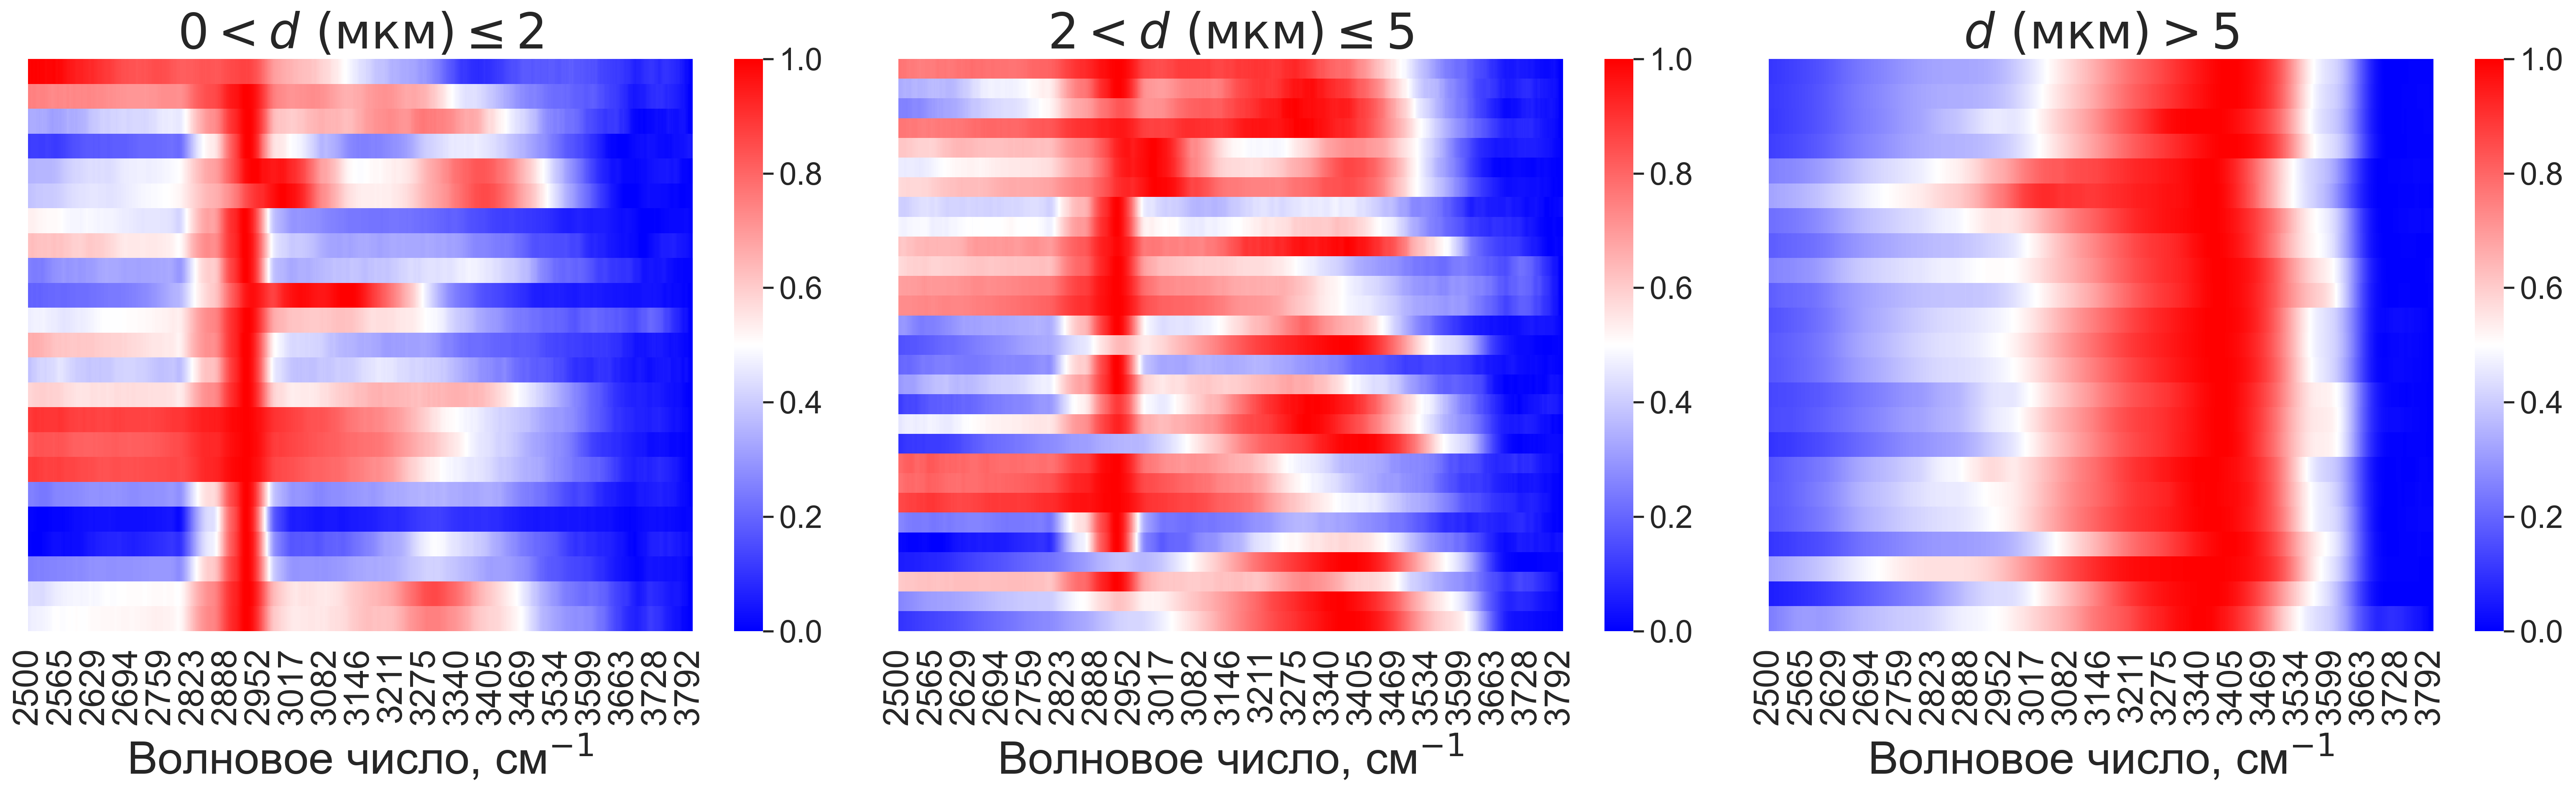

In [22]:
nrows = 1
ncols = len(sizes_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, 6.5), dpi=300)

wn_range = ranges_lst[0]

# Visualization
for j, size_range in tqdm(enumerate(sizes_lst)):

    idx_lst = samples_description.loc[samples_description['Fraction_grouped_hue'] == size_range].index

    tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

    custom_plot_params["TITLE"] = size_title_dict[size_range]
    
    plot_heatmap(
        data_vis=tmp_data_vis,
        ax=axes[j],
        samples_description=samples_description,
        hue_column='Fraction_grouped_hue',  # Fraction_hue, Fraction_grouped_hue
        yticklabels_column='Row_ID',
        plot_params=custom_plot_params,
        style_params=custom_style,
    )

    axes[j].set_yticklabels([])

plt.tight_layout()

plt.savefig(f'{path_to_save}/heatmap_3800_2500_by_sizes.png', dpi=600)

plt.show()

#### `1900-800` cm$^{-1}$

3it [00:00,  8.41it/s]


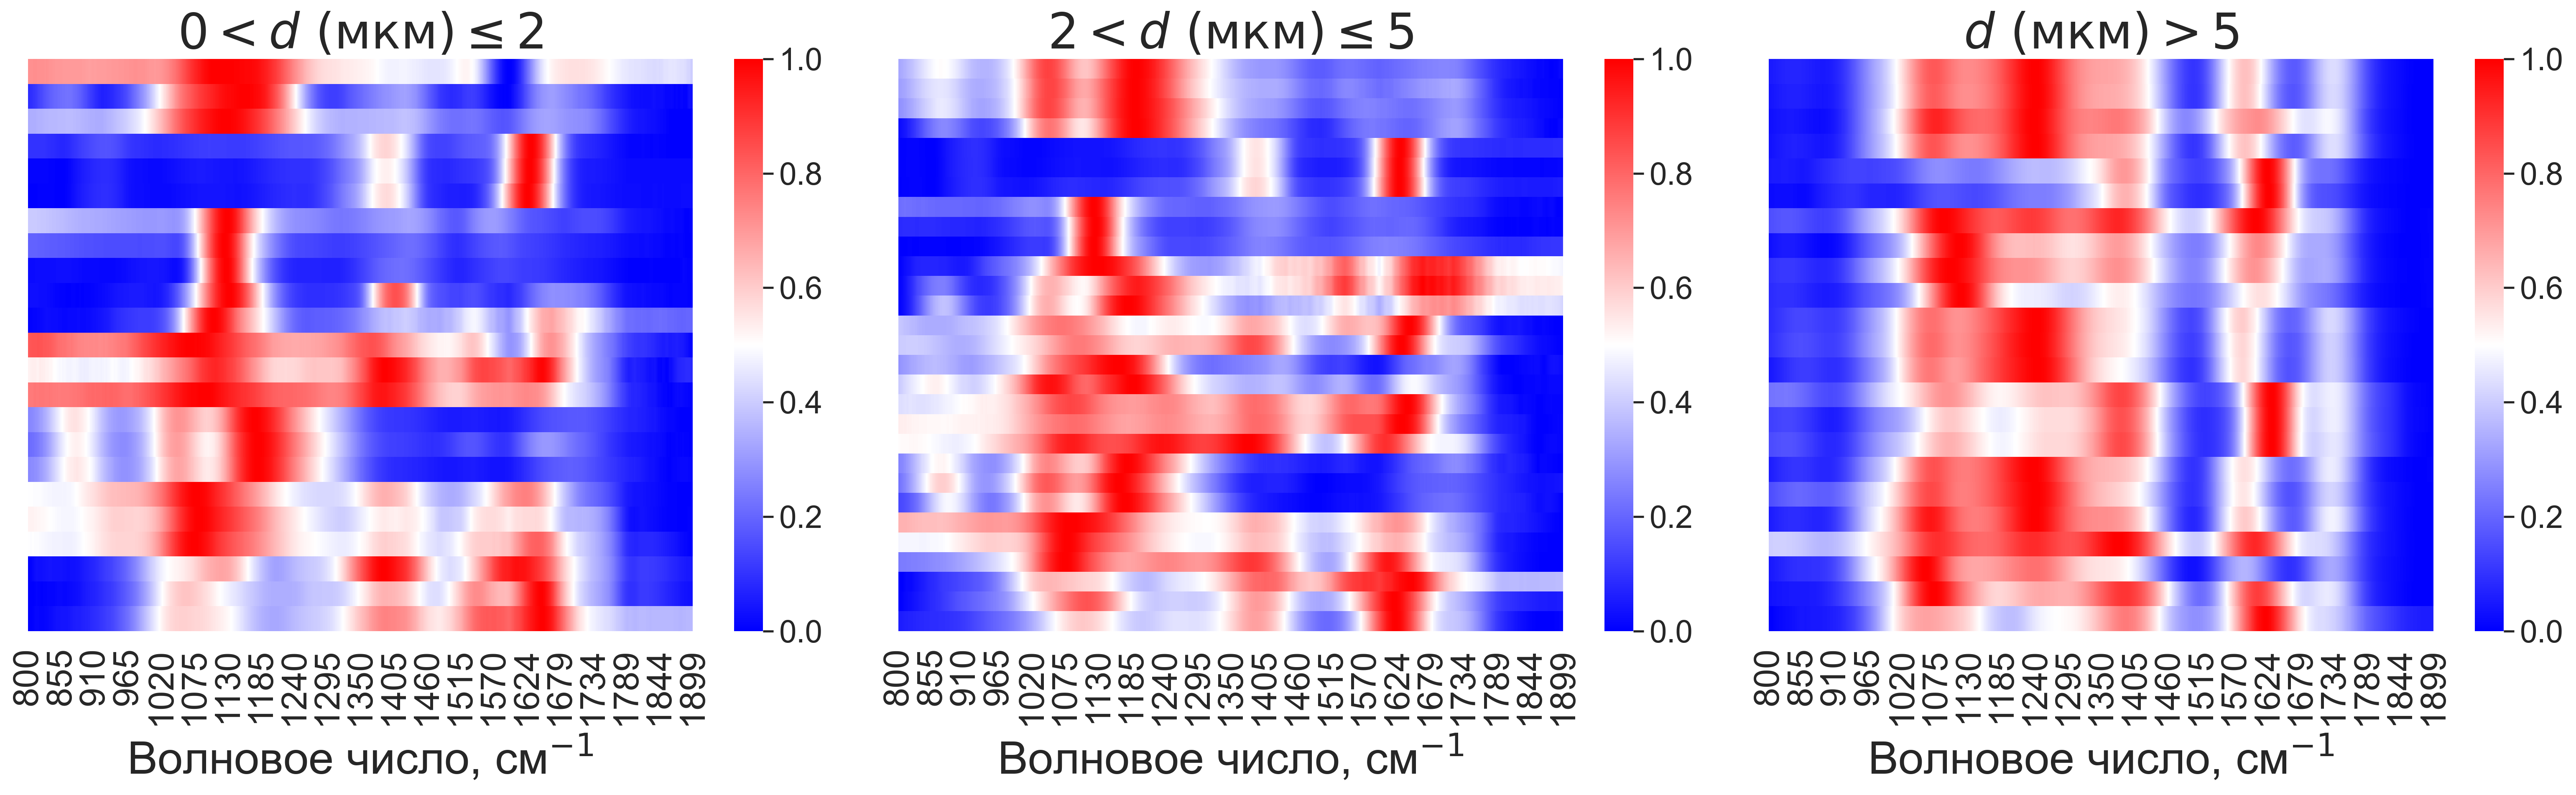

In [23]:
nrows = 1
ncols = len(sizes_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, 6.5), dpi=300)

wn_range = ranges_lst[1]

# Visualization
for j, size_range in tqdm(enumerate(sizes_lst)):

    idx_lst = samples_description.loc[samples_description['Fraction_grouped_hue'] == size_range].index

    tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

    custom_plot_params["TITLE"] = size_title_dict[size_range]
    
    plot_heatmap(
        data_vis=tmp_data_vis,
        ax=axes[j],
        samples_description=samples_description,
        hue_column='Fraction_grouped_hue',  # Fraction_hue, Fraction_grouped_hue
        yticklabels_column='Row_ID',
        plot_params=custom_plot_params,
        style_params=custom_style,
    )

    axes[j].set_yticklabels([])

plt.tight_layout()

plt.savefig(f'{path_to_save}/heatmap_1900_800_by_sizes.png', dpi=600)

plt.show()

## *Mean* spectra plots with confidence intervals

### Function for visualisation

In [24]:
def plot_mean_spectrum_with_ci(data, ax, style_params=None, plot_params=None, confidence=0.95):
    if style_params is None:
        style_params = {
            "TITLE_FONT_SIZE": 16,
            "X_LABEL_FONT_SIZE": 14,
            "Y_LABEL_FONT_SIZE": 14,
            "X_TICK_FONT_SIZE": 12,
            "Y_TICK_FONT_SIZE": 12,
            "LINEWIDTH": 2.5,
            "ALPHA_CI": 0.2,
            "COLOR": "blue"
        }

    if plot_params is None:
        plot_params = {
            "TITLE": "Средний спектр с доверительным интервалом",
            "X_LABEL": "Волновое число, см$^{-1}$",
            "Y_LABEL": "Интенсивность",
            "X_LABELPAD": 5,
            "Y_LABELPAD": 5,
            "X_NBINS": 12,
            "Y_NBINS": 12
        }

    mean_spectrum = data.mean(axis=0)
    std_spectrum = data.std(axis=0)
    n = data.shape[0]

    sem = std_spectrum / np.sqrt(n)

    t_value = t.ppf((1 + confidence) / 2, df=n - 1)

    # Доверительный интервал
    margin = t_value * sem
    lower_bound = np.clip(mean_spectrum - margin, 0, 1)
    upper_bound = np.clip(mean_spectrum + margin, 0, 1)

    ax.plot(
        data.columns,
        mean_spectrum,
        linewidth=style_params["LINEWIDTH"],
        color=style_params["COLOR"]
    )

    ax.fill_between(
        data.columns,
        lower_bound,
        upper_bound,
        alpha=style_params["ALPHA_CI"],
        color=style_params["COLOR"]
    )

    ax.set_title(plot_params["TITLE"], fontsize=style_params["TITLE_FONT_SIZE"], fontstyle='italic')
    
    ax.set_xlabel(plot_params['X_LABEL'], fontsize=style_params["X_LABEL_FONT_SIZE"], labelpad=plot_params["X_LABELPAD"])
    ax.set_ylabel(plot_params['Y_LABEL'], fontsize=style_params["Y_LABEL_FONT_SIZE"], labelpad=plot_params["Y_LABELPAD"], rotation=0)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_params["X_NBINS"]))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_params["Y_NBINS"]))

    ax.tick_params(axis='x', labelsize=style_params["X_TICK_FONT_SIZE"])
    ax.tick_params(axis='y', labelsize=style_params["Y_TICK_FONT_SIZE"])

    ax.invert_xaxis()

### Visualization grouped by fraction sizes

*Config-features for visualization*

In [25]:
custom_plot_params = {
    'TITLE': 'Средний спектр с доверительным интервалом',
    'X_LABEL': 'Волновое число, см$^{-1}$',
    'Y_LABEL': r'$\langle A_{n} \rangle$',
    'X_LABELPAD': 5,
    'Y_LABELPAD': 30,
    'X_NBINS': 3,
    'Y_NBINS': 10
}

custom_style = {
    'Y_LABEL_FONT_SIZE': 26,
    'X_LABEL_FONT_SIZE': 26,
    'X_TICK_FONT_SIZE': 20,
    'Y_TICK_FONT_SIZE': 20,
    'TITLE_FONT_SIZE': 28,
    'LINEWIDTH': 6.0,
    'ALPHA_CI': 0.5,
    'COLOR': 'darkgreen'  # Выбор цвета линии
}

In [26]:
ranges_lst = [
    (3800, 2500),
    (1900, 800)
]

sizes_lst = samples_description['Fraction_grouped_hue'].unique()[::-1]

#### `3800-2500` cm$^{-1}$

3it [00:00, 403.93it/s]


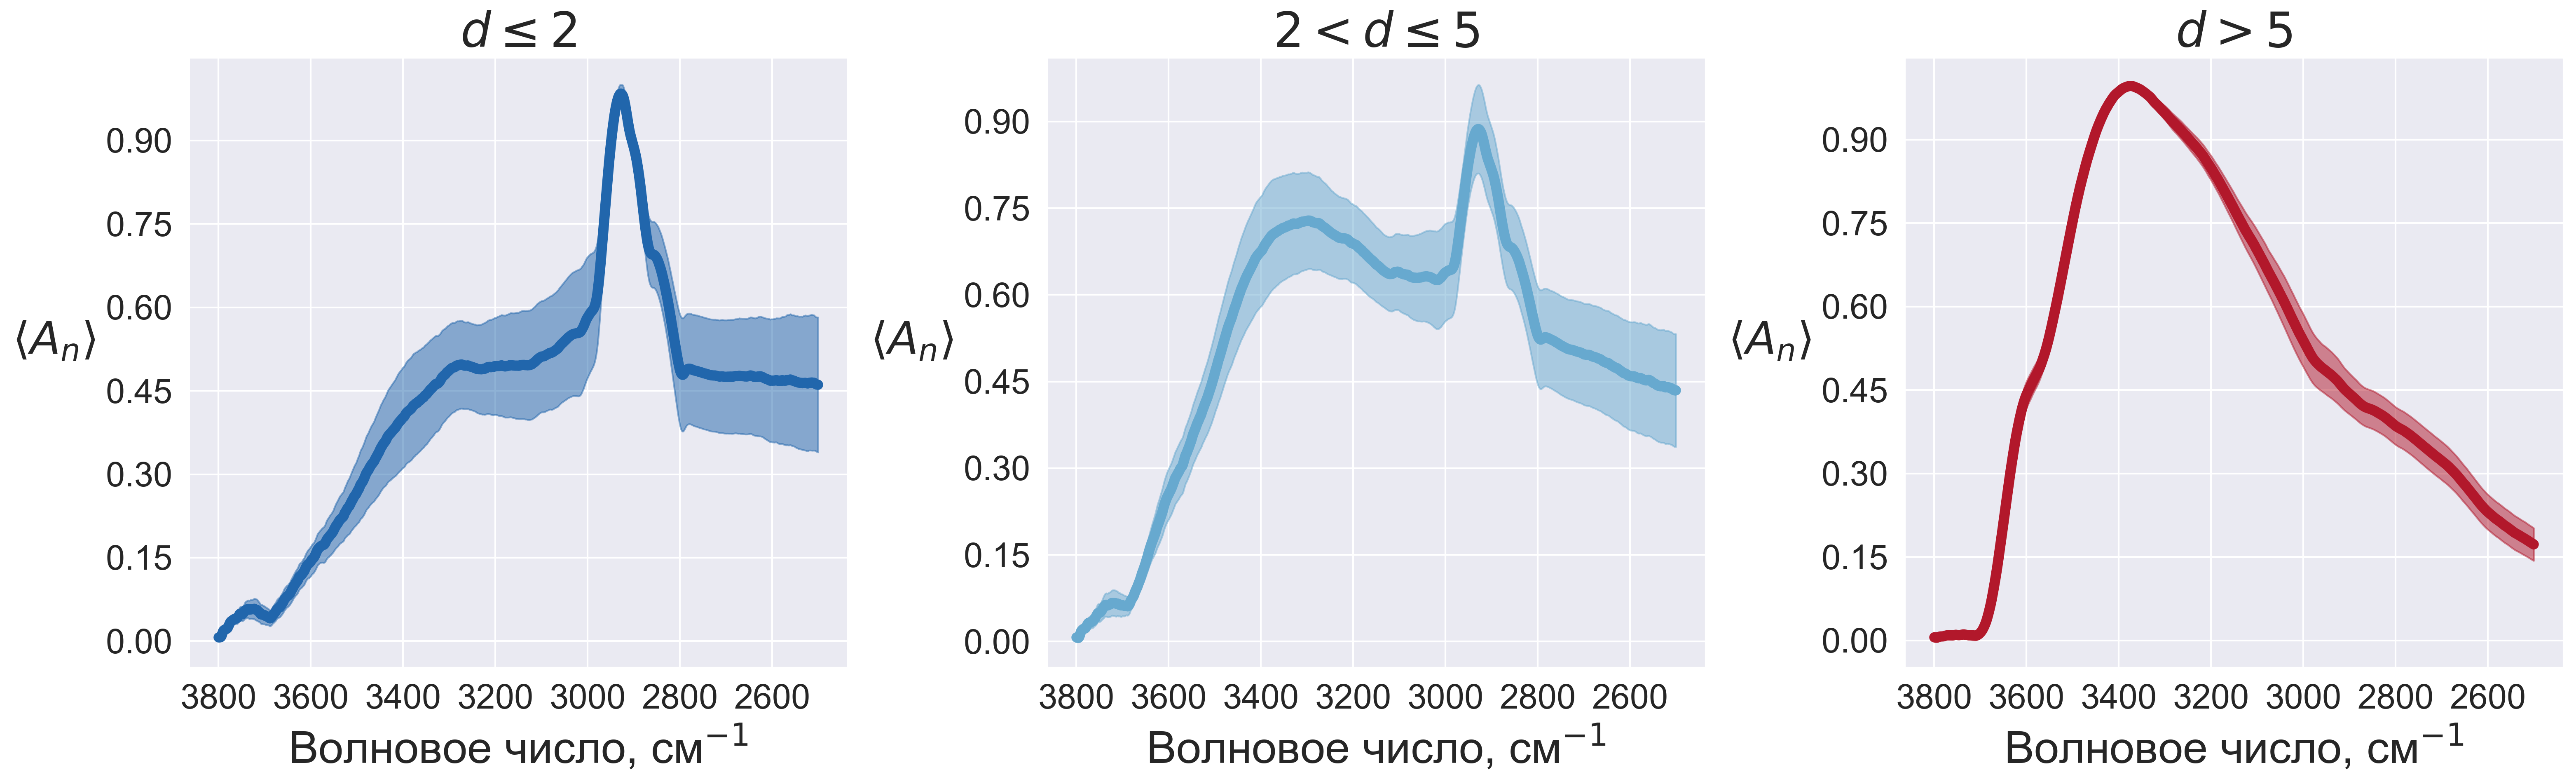

In [27]:
nrows = 1
ncols = len(sizes_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, 6.5), dpi=300)

wn_range = ranges_lst[0]

# Visualization
for j, size_range in tqdm(enumerate(sizes_lst)):
    idx_lst = samples_description.loc[samples_description['Fraction_grouped_hue'] == size_range].index
    tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

    custom_plot_params["TITLE"] = size_range
    custom_plot_params["X_NBINS"] = 8
    
    custom_style["COLOR"] = '#2166AC' if j == 0 else '#67A9CF' if j == 1 else '#B2182B'
    
    plot_mean_spectrum_with_ci(
        data=tmp_data_vis,
        ax=axes[j],
        plot_params=custom_plot_params,
        style_params=custom_style,
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/mean_spectrum_3800_2500_by_sizes.png', dpi=600)

plt.show()

#### `1900-800` cm$^{-1}$

3it [00:00, 434.33it/s]


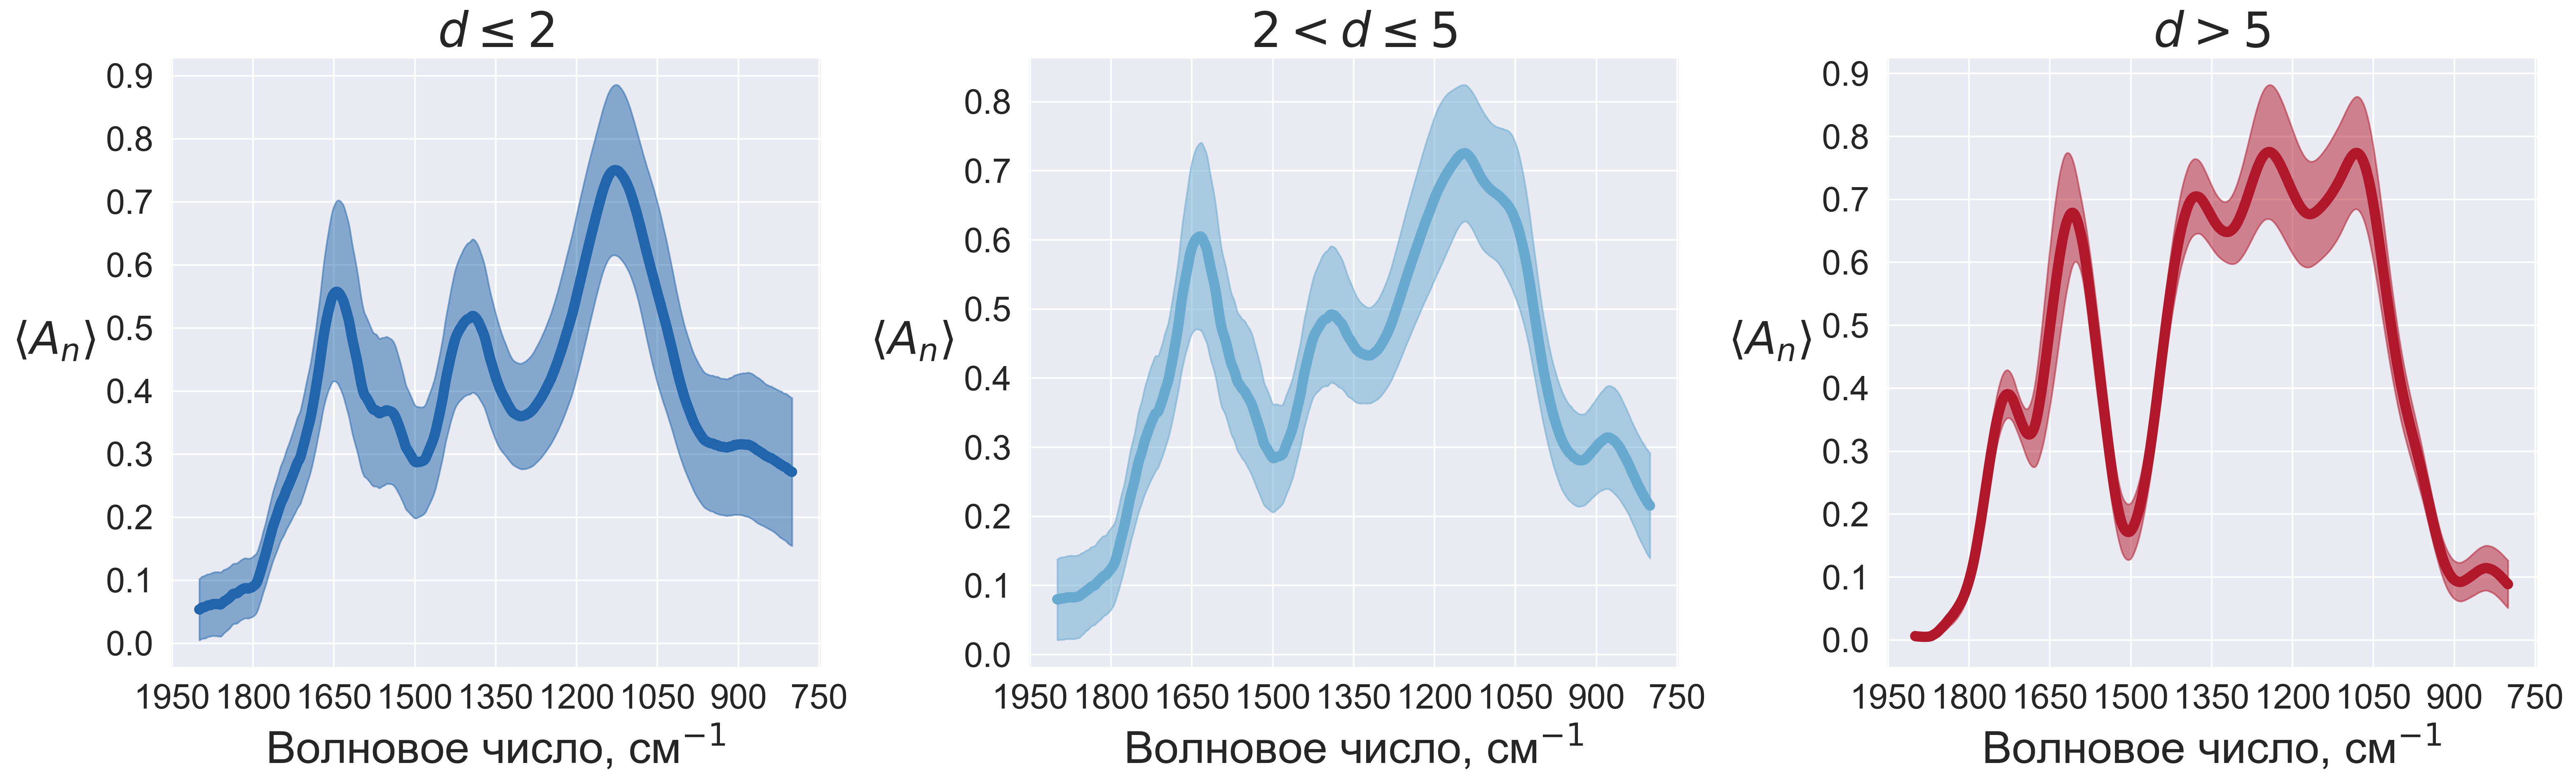

In [28]:
nrows = 1
ncols = len(sizes_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, 6.5), dpi=300)

wn_range = ranges_lst[1]

# Visualization
for j, size_range in tqdm(enumerate(sizes_lst)):
    idx_lst = samples_description.loc[samples_description['Fraction_grouped_hue'] == size_range].index
    tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

    custom_plot_params["TITLE"] = size_range
    custom_plot_params["X_NBINS"] = 10
    
    custom_style["COLOR"] = '#2166AC' if j == 0 else '#67A9CF' if j == 1 else '#B2182B'
    
    plot_mean_spectrum_with_ci(
        data=tmp_data_vis,
        ax=axes[j],
        plot_params=custom_plot_params,
        style_params=custom_style,
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/mean_spectrum_1900_800_by_sizes.png', dpi=600)

plt.show()

## *Reltive standard deviation* ($s_r$) analysis

### Function for visualisation

In [29]:
def plot_rsd_dependence(data, ax, style_params=None, plot_params=None):
    if style_params is None:
        style_params = {
            "TITLE_FONT_SIZE": 16,
            "X_LABEL_FONT_SIZE": 14,
            "Y_LABEL_FONT_SIZE": 14,
            "X_TICK_FONT_SIZE": 12,
            "Y_TICK_FONT_SIZE": 12,
            "LINEWIDTH": 2.5,
            "COLOR": "blue"
        }

    if plot_params is None:
        plot_params = {
            "TITLE": "Относительное стандартное отклонение (sₐₐ)",
            "X_LABEL": "Волновое число, см$^{-1}$",
            "Y_LABEL": "sₐₐ, %",
            "X_LABELPAD": 5,
            "Y_LABELPAD": 5,
            "X_NBINS": 12,
            "Y_NBINS": 12
        }

    mean_spectrum = data.mean(axis=0)
    std_spectrum = data.std(axis=0)

    # Расчет относительного стандартного отклонения
    relative_std = (std_spectrum / mean_spectrum) * 100
    relative_std = relative_std.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Построение графика относительного стандартного отклонения
    ax.plot(
        data.columns,
        relative_std,
        linewidth=style_params["LINEWIDTH"],
        color=style_params["COLOR"]
    )

    ax.set_title(plot_params["TITLE"], fontsize=style_params["TITLE_FONT_SIZE"], fontstyle='italic')
    
    ax.set_xlabel(plot_params['X_LABEL'], fontsize=style_params["X_LABEL_FONT_SIZE"], labelpad=plot_params["X_LABELPAD"])
    ax.set_ylabel(plot_params['Y_LABEL'], fontsize=style_params["Y_LABEL_FONT_SIZE"], labelpad=plot_params["Y_LABELPAD"], rotation=90)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_params["X_NBINS"]))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_params["Y_NBINS"]))

    if plot_params['X_STEP'] is not None:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(plot_params['X_STEP']))
    if plot_params['Y_STEP'] is not None:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(plot_params['Y_STEP']))
    # ax.set_xticks(np.linspace(data.columns.min(), data.columns.max(), plot_params["X_NBINS"]))
    # ax.set_yticks(np.linspace(0, relative_std.max(), plot_params["Y_NBINS"]))

    ax.tick_params(axis='x', labelsize=style_params["X_TICK_FONT_SIZE"])
    ax.tick_params(axis='y', labelsize=style_params["Y_TICK_FONT_SIZE"])

    ax.invert_xaxis()

### Visualization grouped by fraction sizes

*Config-features for visualization*

In [30]:
custom_plot_params = {
    'TITLE': '',
    'X_LABEL': 'Волновое число, см$^{-1}$',
    'Y_LABEL': r'$s_{r}, \%$',
    'X_LABELPAD': 5,
    'Y_LABELPAD': 5,
    'X_NBINS': 3,
    'Y_NBINS': 12,
    'X_STEP': None,
    'Y_STEP': None
}

custom_style = {
    'Y_LABEL_FONT_SIZE': 26,
    'X_LABEL_FONT_SIZE': 26,
    'X_TICK_FONT_SIZE': 20,
    'Y_TICK_FONT_SIZE': 20,
    'TITLE_FONT_SIZE': 28,
    'LINEWIDTH': 6.0,
    'ALPHA_CI': 0.5,
    'COLOR': 'darkgreen'
}

In [31]:
ranges_lst = [
    (3800, 2500),
    (1900, 800)
]

sizes_lst = samples_description['Fraction_grouped_hue'].unique()[::-1]

#### `3800-2500` cm$^{-1}$

3it [00:00, 660.80it/s]


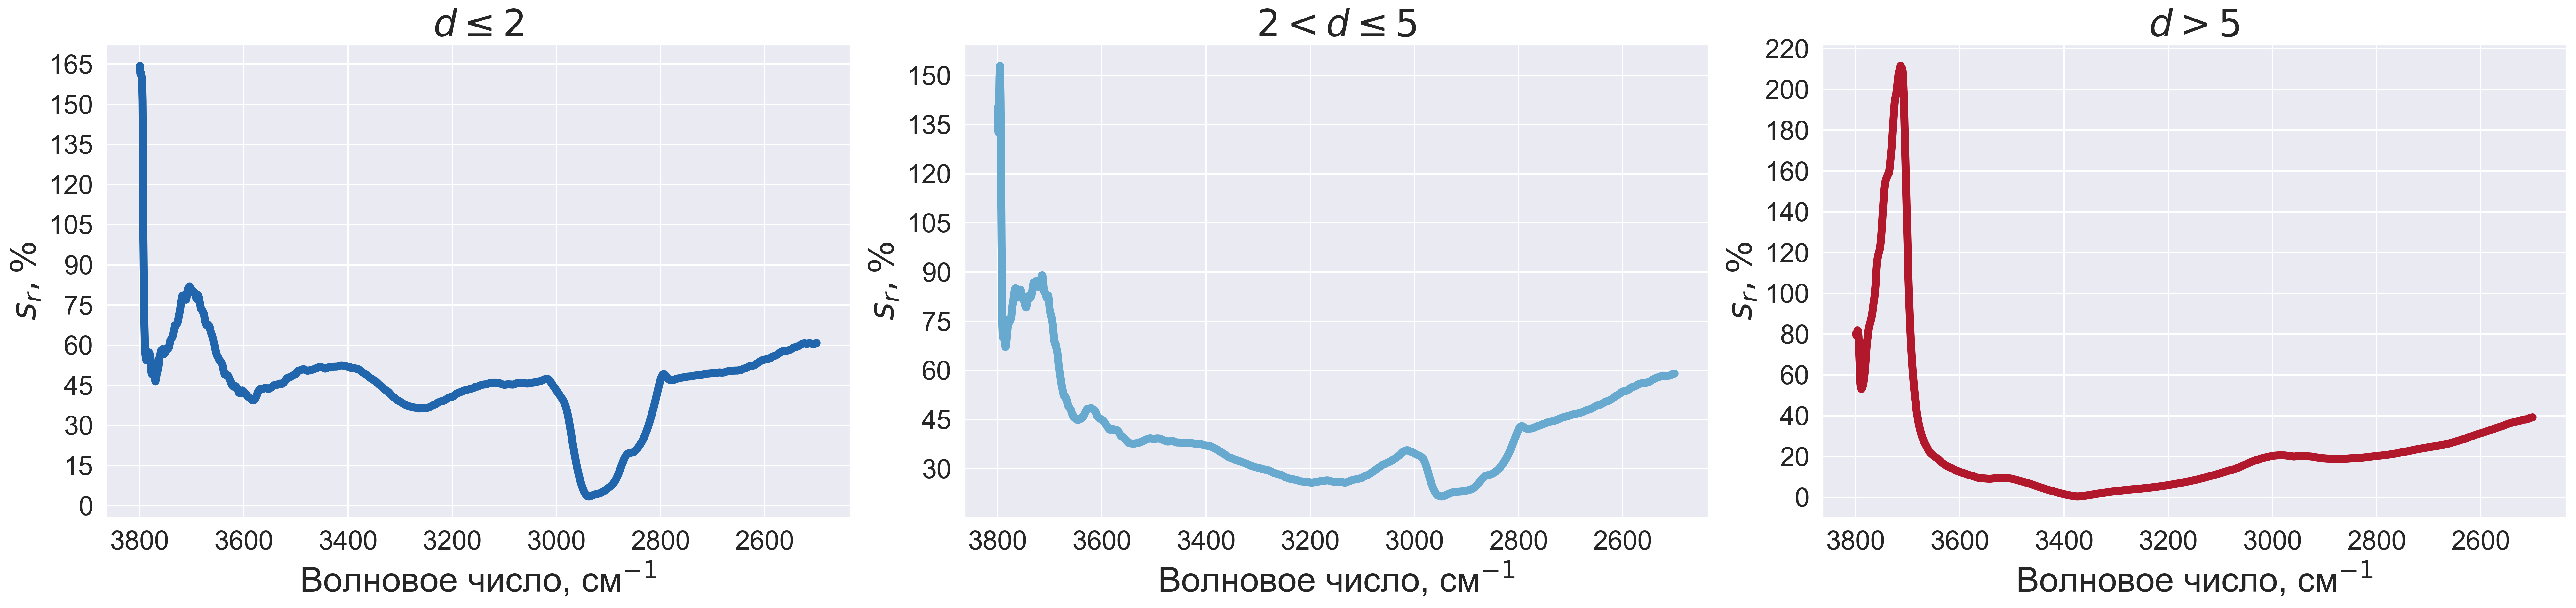

In [32]:
nrows = 1
ncols = len(sizes_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 9, 6.5), dpi=300)

wn_range = ranges_lst[0]

# Visualization
for j, size_range in tqdm(enumerate(sizes_lst)):
    idx_lst = samples_description.loc[samples_description['Fraction_grouped_hue'] == size_range].index
    tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

    custom_plot_params["TITLE"] = size_range
    custom_plot_params["X_STEP"] = 200
    
    custom_style["COLOR"] = '#2166AC' if j == 0 else '#67A9CF' if j == 1 else '#B2182B'
    
    plot_rsd_dependence(
        data=tmp_data_vis,
        ax=axes[j],
        plot_params=custom_plot_params,
        style_params=custom_style,
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/rsd_visualization_3800_2500_by_sizes.png', dpi=600)

plt.show()

#### `1900-800` cm$^{-1}$

3it [00:00, 744.55it/s]


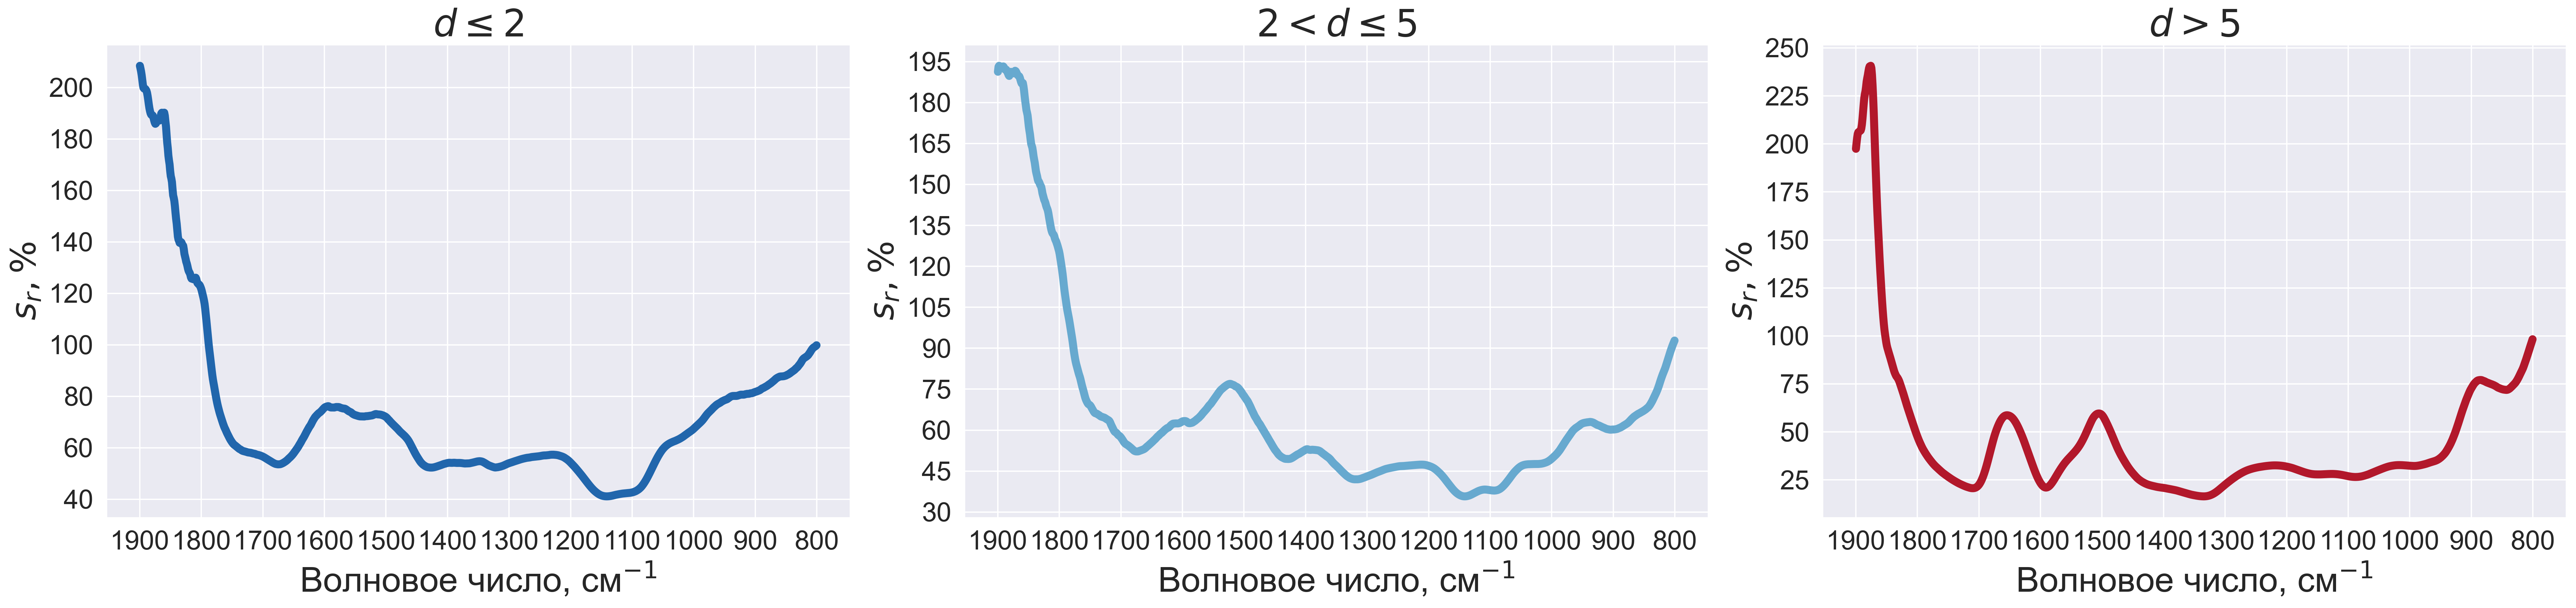

In [33]:
nrows = 1
ncols = len(sizes_lst)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 9, 6.5), dpi=300)

wn_range = ranges_lst[1]

# Visualization
for j, size_range in tqdm(enumerate(sizes_lst)):
    idx_lst = samples_description.loc[samples_description['Fraction_grouped_hue'] == size_range].index
    tmp_data_vis = data_ranges[wn_range].loc[idx_lst]

    custom_plot_params["TITLE"] = size_range
    custom_plot_params["X_STEP"] = 100
    
    custom_style["COLOR"] = '#2166AC' if j == 0 else '#67A9CF' if j == 1 else '#B2182B'
    
    plot_rsd_dependence(
        data=tmp_data_vis,
        ax=axes[j],
        plot_params=custom_plot_params,
        style_params=custom_style,
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/rsd_visualization_1900_800_by_sizes.png', dpi=600)

plt.show()